In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Conv2D, Dense, Flatten, concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Synthetic data generation functions
def generate_synthetic_temporal_data(num_days=365, noise_level=0.1):
    dates = [datetime(2023, 1, 1) + timedelta(hours=i) for i in range(num_days * 24)]
    base_consumption = np.sin(np.arange(len(dates)) * (2 * np.pi / 24)) * 10 + 50  # Daily cycle
    yearly_trend = np.sin(np.arange(len(dates)) * (2 * np.pi / (365 * 24))) * 20  # Yearly cycle
    noise = np.random.normal(0, noise_level, len(dates))
    energy_consumption = base_consumption + yearly_trend + noise
    
    df = pd.DataFrame({
        'timestamp': dates,
        'energy_consumption': energy_consumption
    })
    df.set_index('timestamp', inplace=True)
    return df

def generate_synthetic_spatial_data(num_locations=100):
    lat = np.random.uniform(0, 1, num_locations)
    lon = np.random.uniform(0, 1, num_locations)
    energy_consumption = np.random.uniform(10, 100, num_locations)
    
    df = pd.DataFrame({
        'lat': lat,
        'lon': lon,
        'energy_consumption': energy_consumption
    })
    return df

In [2]:
# Data loading and preprocessing functions
def load_data(temporal_data_path, spatial_data_path):
    # Check if files exist, if not generate synthetic data
    try:
        temporal_data = pd.read_csv(temporal_data_path)
        temporal_data['timestamp'] = pd.to_datetime(temporal_data['timestamp'])
        temporal_data.set_index('timestamp', inplace=True)
        
        spatial_data = pd.read_csv(spatial_data_path)
    except FileNotFoundError:
        print("Data files not found. Generating synthetic data.")
        temporal_data = generate_synthetic_temporal_data()
        spatial_data = generate_synthetic_spatial_data()
        
        # Save synthetic data
        temporal_data.to_csv('synthetic_temporal_data.csv')
        spatial_data.to_csv('synthetic_spatial_data.csv')
        print("Synthetic data saved to 'synthetic_temporal_data.csv' and 'synthetic_spatial_data.csv'")
    
    return temporal_data, spatial_data

def preprocess_temporal_data(data, sequence_length):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data[['energy_consumption']])
    
    X, y = [], []
    for i in range(len(scaled_data) - sequence_length):
        X.append(scaled_data[i:i+sequence_length])
        y.append(scaled_data[i+sequence_length])
    
    return np.array(X), np.array(y), scaler

def preprocess_spatial_data(data, grid_size):
    grid = np.zeros((grid_size, grid_size))
    for _, row in data.iterrows():
        x = int(row['lat'] * grid_size)
        y = int(row['lon'] * grid_size)
        grid[x, y] = row['energy_consumption']
    
    grid = (grid - np.min(grid)) / (np.max(grid) - np.min(grid))
    return grid

# Model creation and training functions
def create_hybrid_model(temporal_input_shape, spatial_input_shape):
    temporal_input = Input(shape=temporal_input_shape)
    lstm = LSTM(64, return_sequences=True)(temporal_input)
    lstm = LSTM(32)(lstm)
    
    spatial_input = Input(shape=spatial_input_shape)
    conv = Conv2D(32, kernel_size=(3, 3), activation='relu')(spatial_input)
    conv = Conv2D(64, kernel_size=(3, 3), activation='relu')(conv)
    conv = Flatten()(conv)
    
    merged = concatenate([lstm, conv])
    
    output = Dense(1)(merged)
    
    model = Model(inputs=[temporal_input, spatial_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    
    return model

In [3]:
def train_model(model, X_temporal, X_spatial, y, epochs=50, batch_size=32):
    history = model.fit(
        [X_temporal, X_spatial], y,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        verbose=1
    )
    return history

In [4]:
# Visualization function
def plot_results(history, y_true, y_pred):
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(122)
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.title('Predictions vs Actual')
    plt.xlabel('Actual Energy Consumption')
    plt.ylabel('Predicted Energy Consumption')
    
    plt.tight_layout()
    plt.show()

# Function to save predictions
def save_predictions(y_true, y_pred, file_path):
    df = pd.DataFrame({
        'Actual': y_true.flatten(),
        'Predicted': y_pred.flatten()
    })
    df.to_csv(file_path, index=False)
    print(f"Predictions saved to {file_path}")

In [6]:
# Main execution
# Load data
temporal_data, spatial_data = load_data('temporal_energy_data.csv', 'spatial_energy_data.csv')

# Preprocess temporal data
sequence_length = 24  # 24 hours of historical data
X_temporal, y, scaler = preprocess_temporal_data(temporal_data, sequence_length)

# Preprocess spatial data
grid_size = 50
X_spatial = preprocess_spatial_data(spatial_data, grid_size)
X_spatial = np.repeat(X_spatial[np.newaxis, :, :, np.newaxis], X_temporal.shape[0], axis=0)

# Split data
X_temporal_train, X_temporal_test, X_spatial_train, X_spatial_test, y_train, y_test = train_test_split(
    X_temporal, X_spatial, y, test_size=0.2, random_state=42)

# Create and train the model
model = create_hybrid_model((sequence_length, 1), (grid_size, grid_size, 1))
history = train_model(model, X_temporal_train, X_spatial_train, y_train)

Data files not found. Generating synthetic data.
Synthetic data saved to 'synthetic_temporal_data.csv' and 'synthetic_spatial_data.csv'
Epoch 1/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - loss: 0.0585 - val_loss: 0.0046
Epoch 2/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 0.0035 - val_loss: 0.0014
Epoch 3/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - loss: 8.1582e-04 - val_loss: 7.2766e-05
Epoch 4/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 8.9066e-05 - val_loss: 7.8849e-05
Epoch 5/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - loss: 1.7181e-04 - val_loss: 3.2744e-05
Epoch 6/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 5.4915e-05 - val_loss: 4.2601e-05
Epoch 7/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 6.9508e-05 - val_loss: 2.4506e-05
Epoch 8/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 4.8622e-05 - val_loss: 3.0389e-05
Epoch 9/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 4.7662e-05 - val_loss: 3.1470e-05
Epoch 10/50
175/175 ━━━━

In [8]:
# Make predictions
y_pred = model.predict([X_temporal_test, X_spatial_test])

# Inverse transform the predictions and actual values
y_pred_original = scaler.inverse_transform(y_pred)
y_test_original = scaler.inverse_transform(y_test)

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


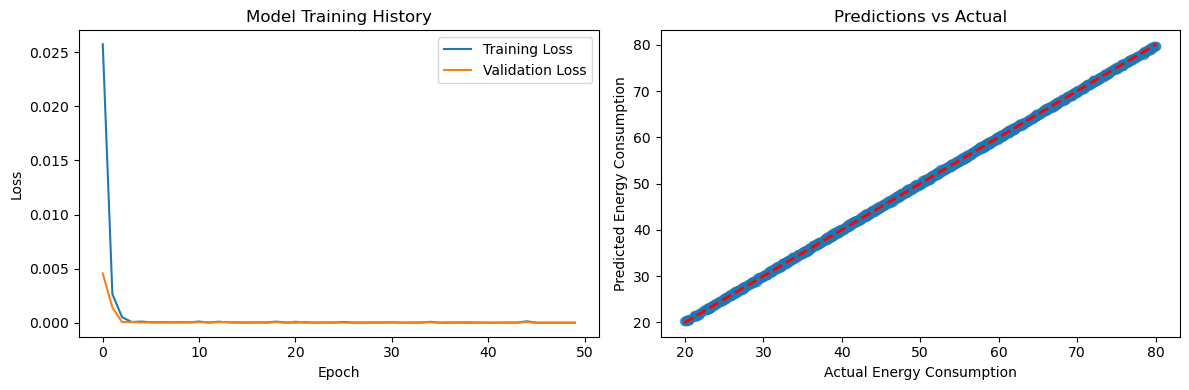

Predictions saved to predictions.csv
Root Mean Square Error: 0.17


In [11]:
# Visualize results
plot_results(history, y_test_original, y_pred_original)

# Save predictions
save_predictions(y_test_original, y_pred_original, 'predictions.csv')

# Calculate and print RMSE
rmse = np.sqrt(np.mean((y_test_original - y_pred_original)**2))
print(f"Root Mean Square Error: {rmse:.2f}")

In [10]:
# Print sample of predictions
print("\nSample of Predictions:")
sample_size = min(10, len(y_test_original))
for i in range(sample_size):
    print(f"Actual: {y_test_original[i][0]:.2f}, Predicted: {y_pred_original[i][0]:.2f}")

# Display the first few rows of the predictions DataFrame
predictions_df = pd.read_csv('predictions.csv')
print("\nFirst few rows of predictions:")
print(predictions_df.head())


Sample of Predictions:
Actual: 60.00, Predicted: 59.80
Actual: 69.69, Predicted: 69.65
Actual: 39.71, Predicted: 39.75
Actual: 58.96, Predicted: 59.04
Actual: 61.74, Predicted: 61.65
Actual: 79.37, Predicted: 78.85
Actual: 72.48, Predicted: 72.55
Actual: 66.80, Predicted: 66.52
Actual: 31.01, Predicted: 31.34
Actual: 67.15, Predicted: 67.13

First few rows of predictions:
      Actual  Predicted
0  60.001299  59.799320
1  69.693910  69.650040
2  39.706421  39.746494
3  58.961269  59.039143
4  61.744760  61.653927
